In [1]:
!pip install -U segmentation_models --quiet
# !pip install tensorflow==2.1.0 --quiet
# !pip install keras ==2.3.1 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.3 MB/s eta 0:00:00


In [47]:
import segmentation_models as sm
# you have to delete the "generic_utils" from the file that makes the segmentatin_models import fail, then restart the runtime

In [2]:
import zipfile
zipfile.ZipFile('/content/ACDC_3.zip', 'r').extractall('/content')

In [50]:
import tensorflow as tf
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import to_categorical

SIZE_X = 256
SIZE_Y = 256

dataset_folder = f'/content/ACDC_3/database'
image_files = sorted(os.listdir(f'{dataset_folder}/train'))
mask_files = sorted(os.listdir(f'{dataset_folder}/trainannot'))
train_images = []
train_masks = []

for img_path, mask_path in zip(image_files, mask_files):
    img = cv2.imread(f'{dataset_folder}/train/{img_path}', 1) #change this to 0 to read it in grayscale
    # img = cv2.resize(img, (SIZE_Y, SIZE_X)) #the images were already the appropriate size
    img = img.astype(float) / 255.0
    train_images.append(img)

    mask = cv2.imread(f'{dataset_folder}/trainannot/{mask_path}', 0)
    # mask = cv2.resize(mask, (SIZE_Y, SIZE_X)) #the masks were already the appropriate size
    mask = mask.astype(float)
    train_masks.append(mask)

train_images = np.array(train_images)
train_masks = np.array(train_masks)

X = train_images
# X = np.expand_dims(X, axis=3) #needed, if we read images as grayscale
Y = train_masks
Y = np.expand_dims(Y, axis=3)


In [52]:
print("Total images in the  dataset: \t", len(train_images))
print("Image data shape is: \t\t", train_images.shape)
# print("Expanded mask data shape is: \t", X.shape)
print("Mask data shape is: \t\t", train_masks.shape)
print("Expanded mask data shape is: \t", Y.shape)
print("Max pixel value in image is: \t", train_images.max())
print("Labels in the mask are : \t", np.unique(train_masks))

Total images in the  dataset: 	 600
Image data shape is: 		 (600, 256, 256, 3)
Mask data shape is: 		 (600, 256, 256)
Expanded mask data shape is: 	 (600, 256, 256, 1)
Max pixel value in image is: 	 1.0
Labels in the mask are : 	 [0. 1. 2. 3.]


(600, 256, 256, 1)
(600, 256, 256, 1)
random number generaterd:  319


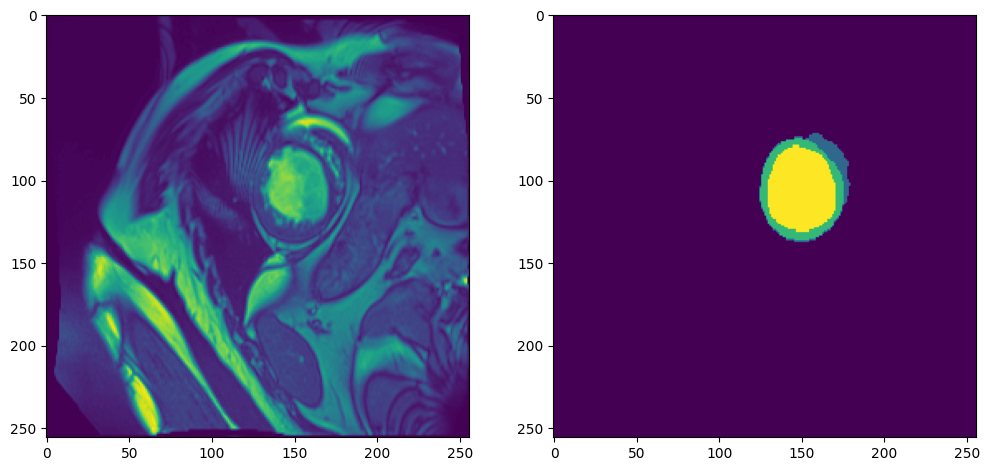

In [36]:
# from google.colab.patches import cv2_imshow
import random

print(X.shape)
print(Y.shape)
i = random.randint(0, 600)
print("random number generaterd: ", i)
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(X[i])
plt.subplot(122)
plt.imshow(Y[i])
# test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
# test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
# plt.subplot(1, 2, 1)
# plt.imshow(test_img, cmap='gray')

In [58]:

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import keras

BACKBONE = 'resnet34'
BATCH_SIZE = 8
EPOCHS = 20
LR = 0.0001
n_classes = 4

preprocess_input = sm.get_preprocessing(BACKBONE)


x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

print("The inputs are:")
print("x_train: \t", x_train.shape)
print("x_val: \t\t", x_val.shape)
print("Class values in the dataset: ", np.unique(y_train))
print("y_train: \t", y_train.shape)
print("y_val: \t\t", y_val.shape)
print("Converting to vategorical data:")
print("y_train_cat: \t", y_train_cat.shape)
print("y_val_cat: \t", y_val_cat.shape)
# print("Class values in the dataset: ", np.unique(y_train_cat))
# print("Class values in the dataset: ", np.unique(y_val_cat))

activation = 'softmax'
optim = keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
loss = total_loss
# loss = sm.losses.DiceLoss(class_indexes=range(1, n_classes + 1))

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
# loss = sm.losses.JaccardLoss()
# metrics = ['accuracy']

model = sm.Unet(BACKBONE, encoder_weights='imagenet', activation=activation, classes=n_classes)
# model = sm.Unet(BACKBONE, input_shape=(256, 256, 3), encoder_weights=None, activation=activation, classes=n_classes)

model.compile(optimizer=optim, loss=loss, metrics=metrics)
# model.compile(optimizer='Adam', loss=loss, metrics=metrics)


print(model.summary())


The inputs are:
x_train: 	 (480, 256, 256, 3)
x_val: 		 (120, 256, 256, 3)
Class values in the dataset:  [0. 1. 2. 3.]
y_train: 	 (480, 256, 256, 1)
y_val: 		 (120, 256, 256, 1)
Converting to vategorical data:
y_train_cat: 	 (480, 256, 256, 4)
y_val_cat: 	 (120, 256, 256, 4)
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding

In [59]:
# it takes about 4 mins to train
history=model.fit(x_train, y_train_cat,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  verbose=1,
                  validation_data=(x_val, y_val_cat))

Epoch 1/20
60/60 [==============================] - 37s 206ms/step - loss: 0.9831 - iou_score: 0.1944 - f1-score: 0.2760 - val_loss: 0.9963 - val_iou_score: 1.2490e-09 - val_f1-score: 1.2490e-09
Epoch 2/20
60/60 [==============================] - 11s 189ms/step - loss: 0.9329 - iou_score: 0.5506 - f1-score: 0.6573 - val_loss: 0.9581 - val_iou_score: 0.2252 - val_f1-score: 0.2370
Epoch 3/20
60/60 [==============================] - 10s 168ms/step - loss: 0.9057 - iou_score: 0.7044 - f1-score: 0.8089 - val_loss: 0.9486 - val_iou_score: 0.2404 - val_f1-score: 0.2451
Epoch 4/20
60/60 [==============================] - 10s 171ms/step - loss: 0.8768 - iou_score: 0.7668 - f1-score: 0.8575 - val_loss: 0.9470 - val_iou_score: 0.2405 - val_f1-score: 0.2451
Epoch 5/20
60/60 [==============================] - 11s 186ms/step - loss: 0.8460 - iou_score: 0.8017 - f1-score: 0.8827 - val_loss: 0.9479 - val_iou_score: 0.2405 - val_f1-score: 0.2451
Epoch 6/20
60/60 [==============================] - 11s 1

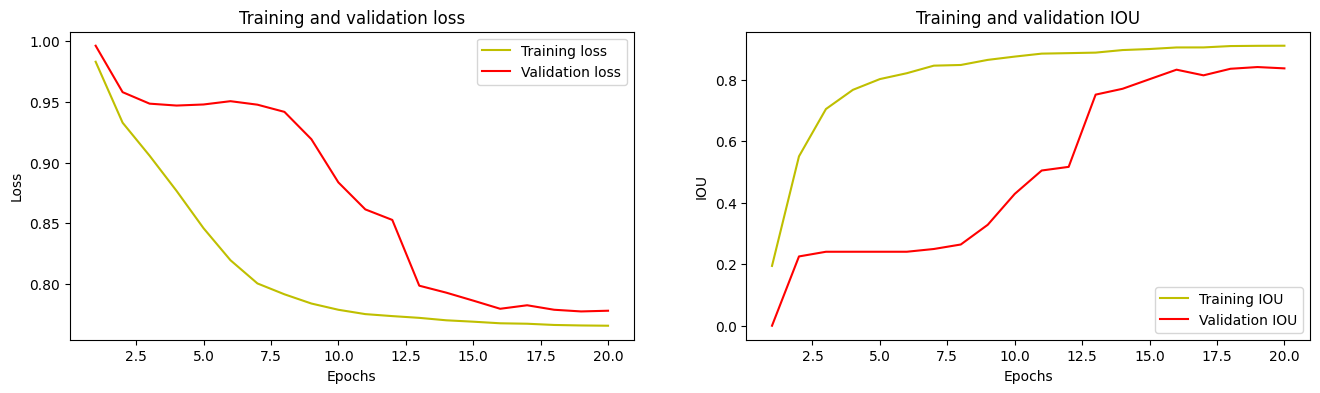

In [69]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
epochs = range(1, len(loss) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(epochs, loss, 'y', label='Training loss')
ax1.plot(epochs, val_loss, 'r', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, acc, 'y', label='Training IOU')
ax2.plot(epochs, val_acc, 'r', label='Validation IOU')
ax2.set_title('Training and validation IOU')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('IOU')
ax2.legend()

plt.show()

In [ ]:
model.save('base_model_test.h5')

1/1 [==============================] - 0s 25ms/step


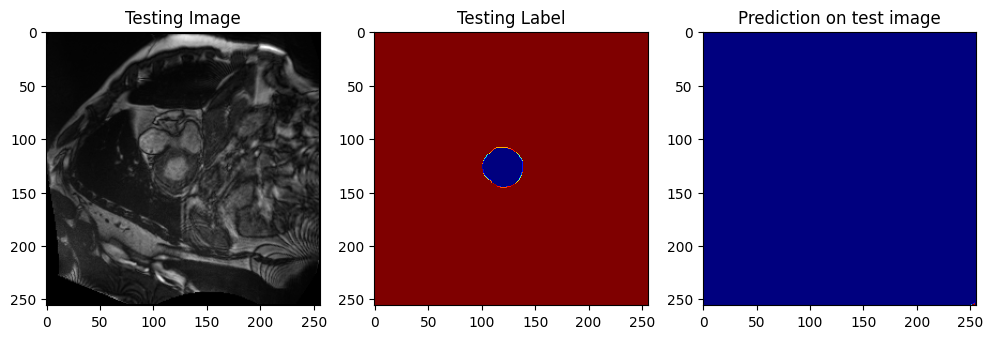

In [89]:
# y_pred = model.predict(x_val)
# y_pred_argmax = np.argmax(y_pred, axis=3)
# plt.imshow(train_images[0, :, :, 0], cmap='gray')
# plt.imshow(train_masks[0], cmap='gray')

import random
test_img_number = random.randint(0, len(x_val))
test_img = x_val[test_img_number]
ground_truth = y_val_cat[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input(test_img_input)

test_pred1 = model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

random i:  144
(256, 256)
expanded test img: 		 (1, 256, 256)


ValueError: ignored

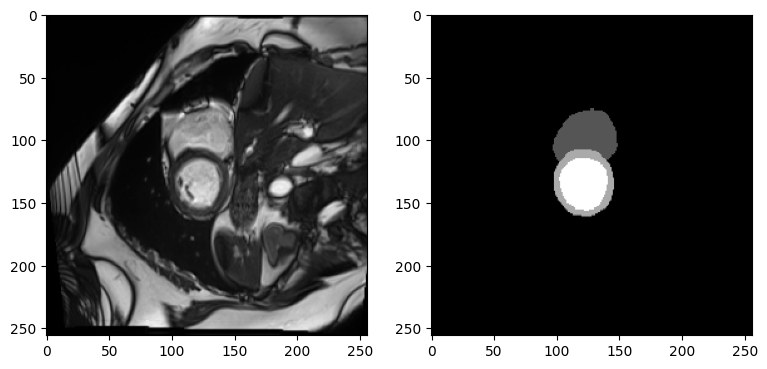

In [61]:

# from tensorflow import keras
# model = keras.models.load_model('base_model_test.h5', compile=False)

plt.figure(figsize=(24, 8))

i = random.randint(101, 150)
print("random i: ", i)
test_img = cv2.imread(f'./ACDC_3/database/test/patient{i}_1_1.png', 0)
# test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
print(test_img.shape)
# test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
plt.subplot(151)
plt.imshow(test_img, cmap='gray')

gt_image = cv2.imread(f'./ACDC_3/database/testannot/patient{i}_1_1.png', 0)
plt.subplot(152)
plt.imshow(gt_image, cmap='gray')

test_img_1 = np.expand_dims(test_img, axis=0)
print("expanded test img: \t\t", test_img_1.shape)
prediction_1 = model.predict(test_img_1)
print("predicted img: \t\t\t", prediction_1.shape)
prediction_image_1 = prediction_1.reshape((256,256,4))
print("predicted img reshaped: \t", prediction_image_1.shape)
plt.subplot(153)
plt.imshow(prediction_image_1)

test_img_2 = preprocess_input(np.expand_dims(test_img, axis=0))
prediction_2 = model.predict(test_img_2)
prediction_image_2 = prediction_2.reshape((256,256,4))
plt.subplot(154)
plt.imshow(prediction_image_2)


# plt.imsave('./test_segmented.jpg', prediction_image)

pred_im = model.predict(preprocess_input(np.expand_dims(cv2.imread(f'./ACDC_3/database/test/patient{i}_1_1.png', 0), axis=0)))
print("asd img : \t", np.squeeze(pred_im, axis=0).shape)
class_masks = np.squeeze(pred_im, axis=0)[:, :, :4]  # Assuming the class probabilities are in the last 4 channels
composite_mask = np.argmax(class_masks, axis=-1)
plt.subplot(155)
plt.imshow(composite_mask, vmin=0, vmax=3)  # Adjust colormap and limits as needed (0 to num_classes - 1)
plt.colorbar(ticks=range(4))  # Add ticks for each class (0 to num_classes - 1)
plt.show()

# test_img_2 = preprocess_input(np.expand_dims(test_img, axis=0))
# print(test_img_2.shape)
# prediction_2 = model.predict(test_img_2)
# prediction_image_2 = np.squeeze(prediction_2, axis=0) #prediction_2.reshape((256,256,4))
# plt.subplot(154)
# plt.imshow(prediction_image_2)

In [ ]:
# evaluate: test dataaset, model.load_weights('best_model.h5') ,
# print("Loss: {:.5}".format(scores[0]))
# for metric, value in zip(metrics, scores[1:]):
#     print("mean {}: {:.5}".format(metric.__name__, value))

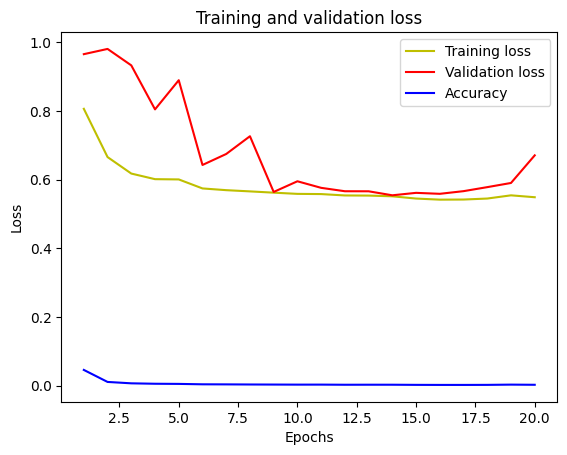

In [39]:
# accuracy = model.evaluate(x_val, y_val)
# plot the training and validation accuracy and loss at each epoch

# # ez a része volt használva
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# accuracy = history.history['accuracy']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.plot(epochs, accuracy, 'b', label='Accuracy')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# plt.figure(figsize=(30, 5))
# plt.subplot(121)
# plt.plot(history.history['iou_score'])
# plt.plot(history.history['val_iou_score'])
# plt.title('Model iou_score')
# plt.ylabel('iou_score')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')

# # Plot training & validation loss values
# plt.subplot(122)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()